# Descarga

Voy a descargar los datos de beauty y health.


##Librerías que usaremos


In [ ]:
!pip install pyLDAvis

     |████████████████████████████████| 1.7 MB 6.9 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=af75460660a26286dd925db3b6e15bfa7798a42ee7de7d8f10e3799784e1b1ff
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
Successfully built pyLDAvis


In [ ]:
from google.colab import drive
import json
import pandas as pd
import gzip
import spacy
import random
from collections import Counter
import re
import numpy as np
from textblob import TextBlob

from nltk import ngrams
from nltk.probability import FreqDist
# Eliminar stop words
from spacy.lang.en.stop_words import STOP_WORDS
from textblob import TextBlob

import gensim
from gensim.corpora import Dictionary
from gensim.models import LdaModel, CoherenceModel
from gensim.models import Word2Vec
from gensim.models.word2vec import LineSentence
from gensim.models import FastText
from gensim.models.callbacks import CallbackAny2Vec

import pyLDAvis
import matplotlib.pyplot as plt
from wordcloud import WordCloud

import csv
import time

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pickle
from wordcloud import WordCloud

from gensim.models import Word2Vec
from gensim.models.word2vec import LineSentence
from sklearn.manifold import TSNE
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


In [ ]:
#Lo conectamos con drive para descargar de ahí los ficheros
drive.mount('/content/drive') 

Mounted at /content/drive


In [ ]:
def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield eval(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')



In [ ]:
#Leemos los datos de reviews de productos de belleza
Beauty_data= getDF('/content/drive/MyDrive/Practica NLP/reviews_Beauty_5.json.gz')

In [ ]:
Beauty_data.head()

reviewerID        asin  ... unixReviewTime   reviewTime
0  A1YJEY40YUW4SE  7806397051  ...     1391040000  01 30, 2014
1   A60XNB876KYML  7806397051  ...     1397779200  04 18, 2014
2  A3G6XNM240RMWA  7806397051  ...     1378425600   09 6, 2013
3  A1PQFP6SAJ6D80  7806397051  ...     1386460800   12 8, 2013
4  A38FVHZTNQ271F  7806397051  ...     1382140800  10 19, 2013

[5 rows x 9 columns]

Voy a crear una columna que contenga el tipo de producto ( Beauty/health) por si quiero ver luego de forma aislada cada uno.

In [ ]:
Beauty_data['Producto'] = 'Beauty'

In [ ]:
#Leemos los datos de reviews de productos de cuidado personal
Health_data =  getDF('/content/drive/MyDrive/Practica NLP/reviews_Health_and_Personal_Care_5.json.gz')

In [ ]:
Health_data.head()

reviewerID        asin  ... unixReviewTime   reviewTime
0   ALC5GH8CAMAI7  159985130X  ...     1294185600   01 5, 2011
1   AHKSURW85PJUE  159985130X  ...     1329523200  02 18, 2012
2   A38RMU1Y5TDP9  159985130X  ...     1275955200   06 8, 2010
3  A1XZUG7DFXXOS4  159985130X  ...     1202428800   02 8, 2008
4  A1MS3M7M7AM13X  159985130X  ...     1313452800  08 16, 2011

[5 rows x 9 columns]

In [ ]:
Health_data['Producto'] = 'Health'

In [ ]:
#Concatenamos ambas reviews
data = pd.concat([Beauty_data,Health_data])
data.head()

reviewerID        asin  ...   reviewTime Producto
0  A1YJEY40YUW4SE  7806397051  ...  01 30, 2014   Beauty
1   A60XNB876KYML  7806397051  ...  04 18, 2014   Beauty
2  A3G6XNM240RMWA  7806397051  ...   09 6, 2013   Beauty
3  A1PQFP6SAJ6D80  7806397051  ...   12 8, 2013   Beauty
4  A38FVHZTNQ271F  7806397051  ...  10 19, 2013   Beauty

[5 rows x 10 columns]

In [ ]:
#Creamos una función que considere negativas las reviews con una valoración de menos de 3
def label_sentiment(row):
    if int(row['overall']) < 3:
        return 1
    else:
        return 0

In [ ]:
#Creamos una columna con la etiqueta
data['sentiment_label'] = data.apply(lambda row: label_sentiment(row), axis=1)

In [ ]:
data.to_pickle("/content/drive/MyDrive/Practica NLP/data.pkl") 

# Cardinalidad

In [ ]:
#nlp_en = spacy.load('en_core_web_sm')

/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:126: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):


In [ ]:
data.shape

(544857, 11)

In [ ]:
reviews = []
for text in data['reviewText']:
    reviews.append(text) 

In [ ]:
#Examinamos el corpus
reviews[:10]

['Very oily and creamy. Not at all what I expected... ordered this to try to highlight and contour and it just looked awful!!! Plus, took FOREVER to arrive.',
 'This palette was a decent price and I was looking for a few different shades. This palette conceals decently, however, it does somewhat cake up and crease.',
 "The texture of this concealer pallet is fantastic, it has great coverage and a wide variety of uses, I guess it's meant for professional makeup artists and a lot of the colours are of no use to me but I use at least two of them on a regular basis, and two more occasionally, which is the only reason I'm giving it for stars, I feel like the range of colors is kind of a waste for me, but the  product itself  is wonderful, it's not cakey, gives me a natural for and concealed my imperfections, therefore I highly recommend it :)",
 "I really can't tell what exactly this thing is. It's not powder but a kind of oil-ish pasty fluid. And so far I tried twice but it doesnt really s

In [ ]:
def words(text): 
  return re.findall(r"([a-z']+)", text.lower())

In [ ]:
text = ' '.join(list(filter(None, reviews)))
text = text.replace("\\","")
list_words = words(text)
words = Counter(words(text))

In [ ]:
#Vemos una dataframe con las palabras y el número de veces que se repiten ( tenemos 174114 palabras distintas)
counted_df = pd.DataFrame(words.items(), columns=['word', 'count']).sort_values('count', ascending=False).reset_index(drop=True) 
counted_df.head()
counted_df.shape

(174114, 2)

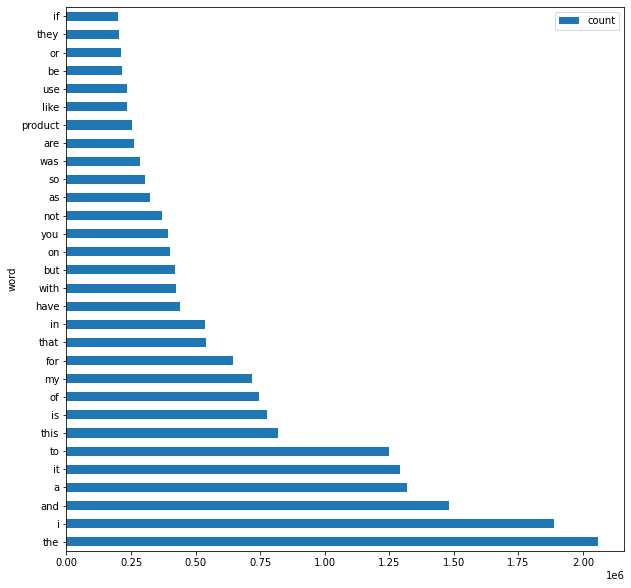

In [ ]:
#Representamos las 30 palabras que más se repiten
counted_df[:30].plot.barh(x='word', y='count',figsize=(10,10))
plt.show()


Vemos en el gráfico, que la mayoría de las palabras representadas no aportan información, stopwords, ya que todavía no hemos hecho un preprocesado de las reviews.

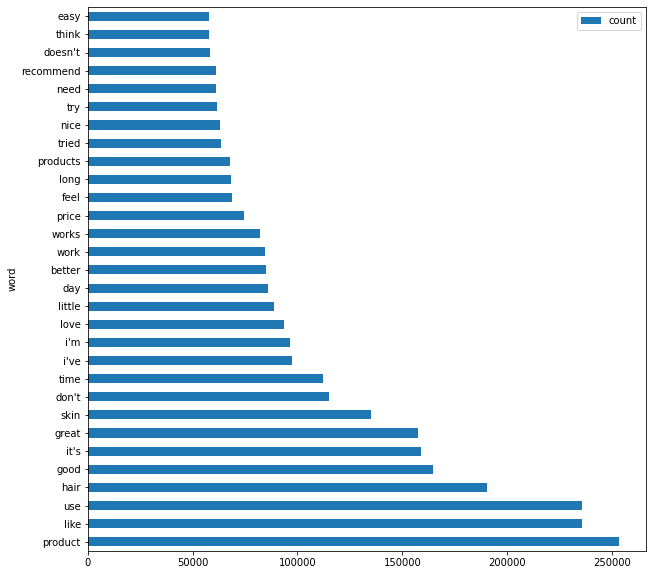

In [ ]:
#Elimino los stopwords para tratar de analizar las palabras más frecuentes.
filter = ~counted_df.word.isin(STOP_WORDS)
counted_df_filter = counted_df[filter]
counted_df_filter=counted_df_filter.loc[((counted_df_filter['word']).str.len()>1) & ((counted_df_filter['word']).str.isnumeric()==False)]
counted_df_filter[:30].plot.barh(x='word', y='count',figsize=(10,10))
plt.show()


Vemos que la palabra más repetida es product, que si sumamos a la palabra products aparece, con diferencia, la que más veces. Dicha palabra es genérica de las reviews y no aportará información al análisis.

#Distribución de reviews según puntuación

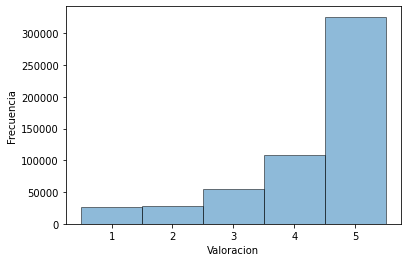

In [ ]:
bins = range(6)
#.plot.hist(alpha=0.5, bins=bins, grid = True,rwidth=0.85)

n_bins = 5
n, bins, patches = plt.hist(data['overall'], bins=n_bins, edgecolor='black',alpha=0.5)
ticks = [(patch._x0 + patch._x1)/2 for patch in patches]
ticklabels = [i+1 for i in range(n_bins)]
plt.xticks(ticks, ticklabels)
plt.xlabel('Valoracion')
plt.ylabel('Frecuencia')
plt.show()


Vemos que la mayoría de las reviews son positivas, por tanto parece que el dataset está bastante desbalanceado. Lo voy a ver por tipo de producto:

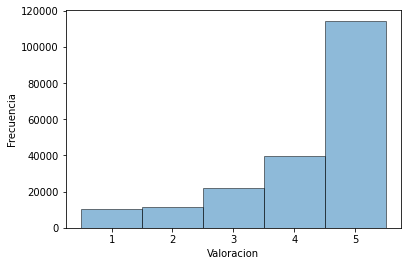

In [ ]:
#Beauty
n, bins, patches = plt.hist(data['overall'].loc[data['Producto'] =='Beauty'], bins=n_bins, edgecolor='black',alpha=0.5)
ticks = [(patch._x0 + patch._x1)/2 for patch in patches]
ticklabels = [i+1 for i in range(n_bins)]
plt.xticks(ticks, ticklabels)
plt.xlabel('Valoracion')
plt.ylabel('Frecuencia')
plt.show()

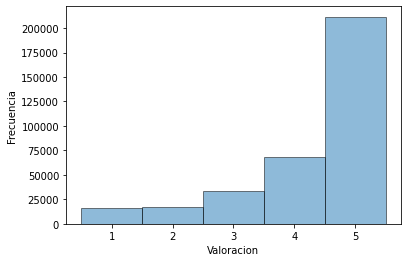

In [ ]:
#Health
n, bins, patches = plt.hist(data['overall'].loc[data['Producto'] =='Health'], bins=n_bins, edgecolor='black',alpha=0.5)
ticks = [(patch._x0 + patch._x1)/2 for patch in patches]
ticklabels = [i+1 for i in range(n_bins)]
plt.xticks(ticks, ticklabels)
plt.xlabel('Valoracion')
plt.ylabel('Frecuencia')
plt.show()

Podemos ver que en cuanto a distribución son similares

#Número de reviews positivas y negativas

In [ ]:
data['sentiment_label'].value_counts()/data.shape[0]


0    0.898539
1    0.101461
Name: sentiment_label, dtype: float64

El número de reviews negativas está entorno al 10%.

#Análisis de las estrellas

Cargamos el csv que contiene solo valoraciones con estrellas. 

In [ ]:
Beauty_estrellas= pd.read_csv('/content/drive/MyDrive/Practica NLP/ratings_Beauty.csv',header=None,names=['id','colb','rating', 'colc'])
Health_estrellas= pd.read_csv('/content/drive/MyDrive/Practica NLP/ratings_Health_and_Personal_Care.csv',header=None,names=['id','colb','rating', 'colc'])

In [ ]:
data_estrellas = pd.concat([Beauty_estrellas[['id','rating']],Health_estrellas[['id','rating']]])
data_estrellas.head()

id  rating
0  A39HTATAQ9V7YF     5.0
1  A3JM6GV9MNOF9X     3.0
2  A1Z513UWSAAO0F     5.0
3  A1WMRR494NWEWV     4.0
4  A3IAAVS479H7M7     1.0

In [ ]:
data_estrellas['rating'].value_counts()/data_estrellas.shape[0]

5.0    0.606516
4.0    0.159266
1.0    0.095704
3.0    0.082196
2.0    0.056319
Name: rating, dtype: float64

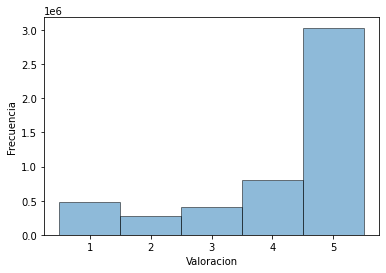

In [ ]:
n, bins, patches = plt.hist(data_estrellas['rating'], bins=n_bins, edgecolor='black',alpha=0.5)
ticks = [(patch._x0 + patch._x1)/2 for patch in patches]
ticklabels = [i+1 for i in range(n_bins)]
plt.xticks(ticks, ticklabels)
plt.xlabel('Valoracion')
plt.ylabel('Frecuencia')
plt.show()

Vemos que las estrellas siguen estando desbalanceadas, pero es cierto que aumenta ligeramente el número de valoraciones negativas.

#N-gramas más frecuentes

In [ ]:
#ngram_object = TextBlob(' '.join([str(item) for item in reviews]))
#ngram_object
list_words[:10]

['very', 'oily', 'and', 'creamy', 'not', 'at', 'all', 'what', 'i', 'expected']

In [ ]:
#Bigramas
bigrams_ = list(ngrams(list_words, 2))
  

In [ ]:
bigrams_[:10]

[('very', 'oily'),
 ('oily', 'and'),
 ('and', 'creamy'),
 ('creamy', 'not'),
 ('not', 'at'),
 ('at', 'all'),
 ('all', 'what'),
 ('what', 'i'),
 ('i', 'expected'),
 ('expected', 'ordered')]

Al hacer trigramas la memoria falla, entonces voy a dividir la lista en 4 a ver si así podemos obtener la lista de los trigramas más frecuentes.

In [ ]:
for i in range(4):
  if i == 0:
        trigrams_ = list(ngrams(list_words[:int(len(list_words)/4)], 3))
  else:
        trigrams_.append(ngrams(list_words[int(len(list_words)/4)*i:int(len(list_words)/4)*(i+1)], 3))
  time.sleep(10)      

In [ ]:
trigrams_[:10]

[('very', 'oily', 'and'),
 ('oily', 'and', 'creamy'),
 ('and', 'creamy', 'not'),
 ('creamy', 'not', 'at'),
 ('not', 'at', 'all'),
 ('at', 'all', 'what'),
 ('all', 'what', 'i'),
 ('what', 'i', 'expected'),
 ('i', 'expected', 'ordered'),
 ('expected', 'ordered', 'this')]

In [ ]:
bg_freq = FreqDist(bigrams_)

In [ ]:
bg_freq.most_common(10)

[(('i', 'have'), 195319),
 (('of', 'the'), 147026),
 (('in', 'the'), 135736),
 (('it', 'is'), 134705),
 (('this', 'product'), 125813),
 (('and', 'i'), 109990),
 (('this', 'is'), 109504),
 (('is', 'a'), 104567),
 (('i', 'am'), 88937),
 (('i', 'was'), 88868)]

Da la sensación que tenemos bigramas con muchos stopwords, voy a intentar limpiar estos bigramas y quitar aquellos que contienen stopwords.

In [ ]:
bigrams_clean = [gram for gram in bigrams_ if not any(stop in gram for stop in STOP_WORDS)]

In [ ]:
bg_freq_clean = FreqDist(bigrams_clean )

In [ ]:
bg_freq_clean.most_common(20)

[(('highly', 'recommend'), 16112),
 (('long', 'time'), 12866),
 (('great', 'product'), 12462),
 (('works', 'great'), 11646),
 (("i've", 'tried'), 11385),
 (("don't", 'know'), 11159),
 (('sensitive', 'skin'), 9759),
 (('feel', 'like'), 9687),
 (('fish', 'oil'), 8318),
 (('good', 'product'), 7493),
 (("don't", 'like'), 7120),
 (('years', 'ago'), 7000),
 (('little', 'bit'), 6869),
 (("don't", 'think'), 6414),
 (('dry', 'skin'), 6011),
 (('weight', 'loss'), 5998),
 (('great', 'price'), 5933),
 (('vitamin', 'c'), 5740),
 (('pretty', 'good'), 5680),
 (('highly', 'recommended'), 5401)]

In [ ]:
tg_freq = FreqDist(trigrams_)

In [ ]:
tg_freq.most_common(10)

[(('this', 'is', 'a'), 8740),
 (('a', 'lot', 'of'), 6916),
 (('i', 'love', 'this'), 6076),
 (('i', 'use', 'it'), 5962),
 (('i', 'have', 'been'), 5344),
 (('my', 'hair', 'is'), 4984),
 (('it', 'is', 'a'), 4891),
 (('this', 'is', 'the'), 4668),
 (('on', 'my', 'face'), 4658),
 (('i', 'love', 'the'), 4639)]

Con los trigramas pasa algo parecido, voy a limpiar éstos de stopwords.

In [ ]:
trigrams_clean = [gram for gram in trigrams_ if not any(stop in gram for stop in STOP_WORDS)]

In [ ]:
tg_freq_clean = FreqDist(trigrams_clean)

In [ ]:
tg_freq_clean.most_common(10)

[(('love', 'love', 'love'), 813),
 (('acne', 'prone', 'skin'), 750),
 (('tea', 'tree', 'oil'), 507),
 (('color', 'treated', 'hair'), 374),
 (('skin', 'care', 'products'), 330),
 (('shoulder', 'length', 'hair'), 306),
 (('naturally', 'curly', 'hair'), 288),
 (('nail', 'polish', 'remover'), 286),
 (('e', 'l', 'f'), 274),
 (('little', 'bit', 'goes'), 259)]

In [ ]:
bg_freq_most_common = bg_freq_clean.most_common(10)
bgs_ = [str(bg[0]) for bg in bg_freq_most_common]
bgs_f_ = [bg[1] for bg in bg_freq_most_common]



In [ ]:
bgs_f_, bgs_ = zip(*sorted(zip(bgs_f_, bgs_)))


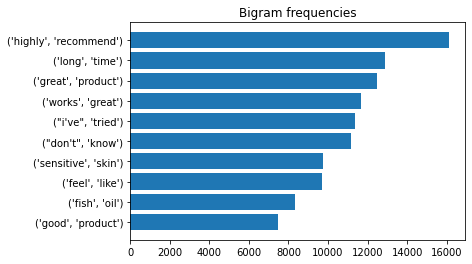

In [ ]:
plt.barh(bgs_, bgs_f_)
plt.title('Bigram frequencies')
plt.show()

In [ ]:
tg_freq_most_common =tg_freq_clean.most_common(10)
tgs_ = [str(tg[0]) for tg in tg_freq_most_common]
tgs_f_ = [tg[1] for tg in tg_freq_most_common]

In [ ]:
tgs_f_, tgs_ = zip(*sorted(zip(tgs_f_, tgs_)))

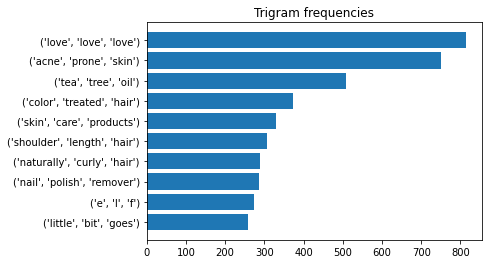

In [ ]:
plt.barh(tgs_, tgs_f_)
plt.title('Trigram frequencies')
plt.show()

#Nube de palabras

In [ ]:
def plot_word_cloud(text,n):
    wordcloud = WordCloud(max_font_size=50, max_words=n, background_color="white",collocations=False).generate(' '.join(text))
    plt.figure(figsize=(12,6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

In [ ]:
words_clean = [word for word in list_words if not any(stop in word for stop in STOP_WORDS)]

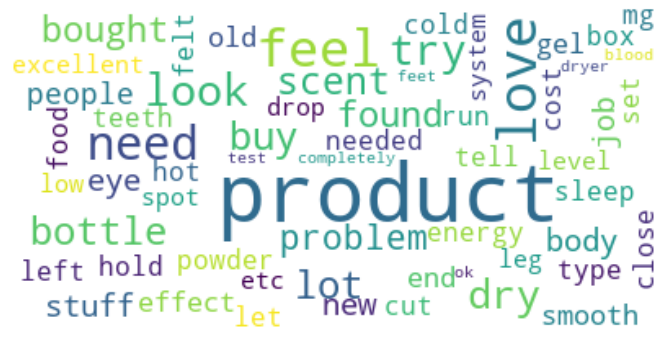

In [ ]:
plot_word_cloud(words_clean,60)

Nube de opiniones positivas

In [ ]:
def words(text): 
  return re.findall(r"([a-z']+)", text.lower())

In [ ]:
reviews_positivas = []
for text in data['reviewText'].loc[data['sentiment_label']==0]:
    reviews_positivas.append(text) 

In [ ]:
text_positivo = ' '.join(list(filter(None, reviews_positivas)))
list_words_positivas = words(text_positivo)

In [ ]:
words_clean_positivas = [word for word in list_words_positivas if not any(stop in word for stop in STOP_WORDS)]

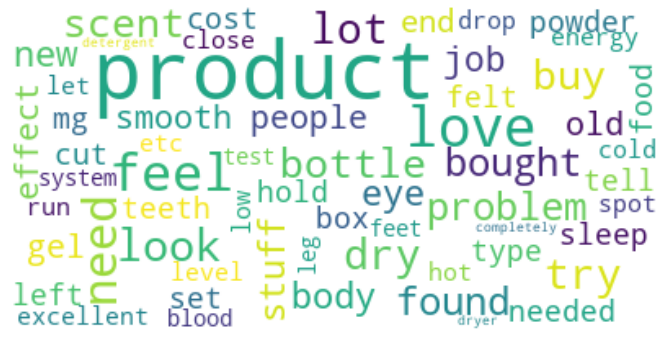

In [ ]:
plot_word_cloud(words_clean_positivas,60)

Nube de opiniones negativas

In [ ]:
reviews_negativas = []
for text in data['reviewText'].loc[data['sentiment_label']==1]:
    reviews_negativas.append(text) 

In [ ]:
text_negativo = ' '.join(list(filter(None, reviews_negativas)))
list_words_negativas = words(text_negativo )

In [ ]:
words_clean_negativas  = [word for word in list_words_negativas if not any(stop in word for stop in STOP_WORDS)]

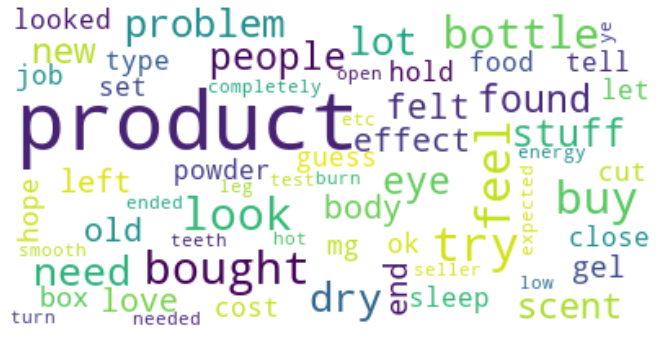

In [ ]:
plot_word_cloud(words_clean_negativas ,60)

#Visualización word2vec

Visualización en 2 dimensiones de algunos word embeddings con word2Vec

In [ ]:
sg_params = {
    'sg': 1,
    'size': 300,
    'min_count': 5,
    'window': 5,
    'hs': 0,
    'negative': 20,
    'workers': 4
}

cbow_params = {
    'sg': 0,
    'size': 300,
    'min_count': 5,
    'window': 5,
    'hs': 0,
    'negative': 20,
    'workers': 4
}

In [ ]:
corpus = []
for text in data['reviewText']:
    corpus.append(re.findall(r"([a-z']+)", text.lower())) 

In [ ]:
# Skip Gram
w2v_sg = Word2Vec(**sg_params)

# CBOW
w2v_cbow = Word2Vec(**cbow_params)

In [ ]:
# Skip Gram
w2v_sg.build_vocab(corpus)

# CBOW
w2v_cbow.build_vocab(corpus)

In [ ]:
print('Vocabulario compuesto por {} palabras'.format(len(w2v_sg.wv.vocab)))

Vocabulario compuesto por 44851 palabras


In [ ]:
print('Vocabulario compuesto por {} palabras'.format(len(w2v_cbow.wv.vocab)))

Vocabulario compuesto por 44851 palabras


In [ ]:
class EpochLogger(CallbackAny2Vec):
      '''Callback to log information about training'''
    
      def __init__(self):
           self.epoch = 0
   
      def on_epoch_begin(self, model):
             print("Epoch #{} start".format(self.epoch))
    
      def on_epoch_end(self, model):
             print("Epoch #{} end".format(self.epoch))
             self.epoch += 1

In [ ]:
# Skip Gram
epoch_logger = EpochLogger()
w2v_sg.train(sentences=corpus, total_examples=w2v_sg.corpus_count, epochs=8, callbacks=[epoch_logger])

Epoch #0 start
Epoch #0 end
Epoch #1 start
Epoch #1 end
Epoch #2 start
Epoch #2 end
Epoch #3 start
Epoch #3 end
Epoch #4 start
Epoch #4 end
Epoch #5 start
Epoch #5 end
Epoch #6 start
Epoch #6 end
Epoch #7 start
Epoch #7 end


(297665856, 404500368)

In [ ]:
w2v_sg.save('/content/drive/MyDrive/Practica NLP/w2v_sg_beautyandhealth.pkl')

/usr/local/lib/python3.7/dist-packages/gensim/utils.py:589: DeprecationWarning: Call to deprecated `cum_table` (Attribute will be removed in 4.0.0, use self.vocabulary.cum_table instead).
  if hasattr(self, attrib):
/usr/local/lib/python3.7/dist-packages/gensim/utils.py:590: DeprecationWarning: Call to deprecated `cum_table` (Attribute will be removed in 4.0.0, use self.vocabulary.cum_table instead).
  asides[attrib] = getattr(self, attrib)
/usr/local/lib/python3.7/dist-packages/gensim/utils.py:591: DeprecationWarning: Call to deprecated `cum_table` (Attribute will be removed in 4.0.0, use self.vocabulary.cum_table instead).
  delattr(self, attrib)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/gensim/

In [ ]:
# CBOW
epoch_logger = EpochLogger()
w2v_cbow.train(sentences=corpus, total_examples=w2v_cbow.corpus_count, epochs=8,callbacks=[epoch_logger])


Epoch #0 start
Epoch #0 end
Epoch #1 start
Epoch #1 end
Epoch #2 start
Epoch #2 end
Epoch #3 start
Epoch #3 end
Epoch #4 start
Epoch #4 end
Epoch #5 start
Epoch #5 end
Epoch #6 start
Epoch #6 end
Epoch #7 start
Epoch #7 end


(297658890, 404500368)

In [ ]:

w2v_cbow.save('/content/drive/MyDrive/Practica NLP/w2v_cbow_beautyandhealth.pkl')

/usr/local/lib/python3.7/dist-packages/gensim/utils.py:589: DeprecationWarning: Call to deprecated `cum_table` (Attribute will be removed in 4.0.0, use self.vocabulary.cum_table instead).
  if hasattr(self, attrib):
/usr/local/lib/python3.7/dist-packages/gensim/utils.py:590: DeprecationWarning: Call to deprecated `cum_table` (Attribute will be removed in 4.0.0, use self.vocabulary.cum_table instead).
  asides[attrib] = getattr(self, attrib)
/usr/local/lib/python3.7/dist-packages/gensim/utils.py:591: DeprecationWarning: Call to deprecated `cum_table` (Attribute will be removed in 4.0.0, use self.vocabulary.cum_table instead).
  delattr(self, attrib)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/gensim/

In [ ]:
def print_sim_words(word, model1, model2):
    query = "Most similar to {}".format(word) 
    print(query)
    print("-"*len(query))
    for (sim1, sim2) in zip(model1.wv.most_similar(word), model2.wv.most_similar(word)):
        print("{}:{}{:.3f}{}{}:{}{:.3f}".format(sim1[0],
                                               " "*(20-len(sim1[0])), 
                                               sim1[1], 
                                               " "*10, 
                                               sim2[0],
                                               " "*(20-len(sim2[0])),
                                               sim2[1]))
    print("\n")

In [ ]:
print_sim_words('smell', w2v_cbow, w2v_sg)
print_sim_words('good', w2v_sg, w2v_sg) # error, se compara con el mismo modelo
print_sim_words('gloss', w2v_cbow, w2v_sg)
print_sim_words('oil', w2v_cbow, w2v_sg)

Most similar to smell
---------------------
scent:               0.864          scent:               0.788
aroma:               0.765          smells:              0.741
fragrance:           0.757          aroma:               0.728
smelling:            0.710          smelling:            0.686
odor:                0.707          odor:                0.683
smells:              0.701          smelled:             0.669
taste:               0.667          fragrance:           0.659
smelled:             0.597          stink:               0.620
aftertaste:          0.569          overpowering:        0.603
flavor:              0.563          perfumy:             0.585


Most similar to good
--------------------
great:               0.690          great:               0.690
decent:              0.645          decent:              0.645
excellent:           0.584          excellent:           0.584
goodcons:            0.555          goodcons:            0.555
nice:                0.551    

/usr/local/lib/python3.7/dist-packages/gensim/matutils.py:737: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if np.issubdtype(vec.dtype, np.int):
/usr/local/lib/python3.7/dist-packages/gensim/matutils.py:737: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link f

#Visualización embedings

In [ ]:
w2v_sg = Word2Vec.load('/content/drive/MyDrive/Practica NLP/w2v_sg_beautyandhealth.pkl')
w2v_cbow =  Word2Vec.load('/content/drive/MyDrive/Practica NLP/w2v_cbow_beautyandhealth.pkl')

/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/gensim/utils.py:488: DeprecationWarning: Call to deprecated `cum_table` (Attribute will be removed in 4.0.0, use self.vocabulary.cum_table instead).
  setattr(self, attrib, None)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/gensim/utils.py:488: DeprecationWarning: Call to deprecated `cum_table` (Attribute will be removed in 4.0.0, use self.vocabulary.cum_table instead).


Los resultados son similares con ambos modelos, de hecho para alguna palabra funciona mejor cbow y para otras sg.
Voy a hacer por tanto una visualización de sg, por ejemplo.

In [ ]:
keys = ['skin', 'hair', 'hands', 'lips']

embedding_clusters = []
word_clusters = []
for word in keys:
    embeddings = []
    words = []
    for similar_word, _ in w2v_sg.wv.most_similar(word, topn=10):
        words.append(similar_word)
        embeddings.append(w2v_sg.wv[similar_word])
    embedding_clusters.append(embeddings)
    word_clusters.append(words)

/usr/local/lib/python3.7/dist-packages/gensim/matutils.py:737: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if np.issubdtype(vec.dtype, np.int):
/usr/local/lib/python3.7/dist-packages/gensim/matutils.py:737: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link f

In [ ]:
tsne_model_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32)

In [ ]:
embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape

In [ ]:
embeddings_2d = np.array(tsne_model_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/scipy/linalg/decomp_qr.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  kwargs['lwork'] = ret[-2][0].real.astype(numpy.int)
/usr/local/lib/python3.7/dist-packages/scipy/linalg/decomp_qr.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will no

In [ ]:
def tsne_plot_similar_words(labels, embedding_clusters, word_clusters, a=0.7):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:,0]
        y = embeddings[:,1]
        plt.scatter(x, y, c=[color], alpha=a, label=label)
        for i, word in enumerate(words):
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2), 
                         textcoords='offset points', ha='right', va='bottom', size=8)
    plt.legend(loc=4)
    plt.grid(True)
    plt.title('Representación en 2D de los embeddings de algunos clusters de palabras')
    # plt.savefig("f/г.png", format='png', dpi=150, bbox_inches='tight')
    plt.show()


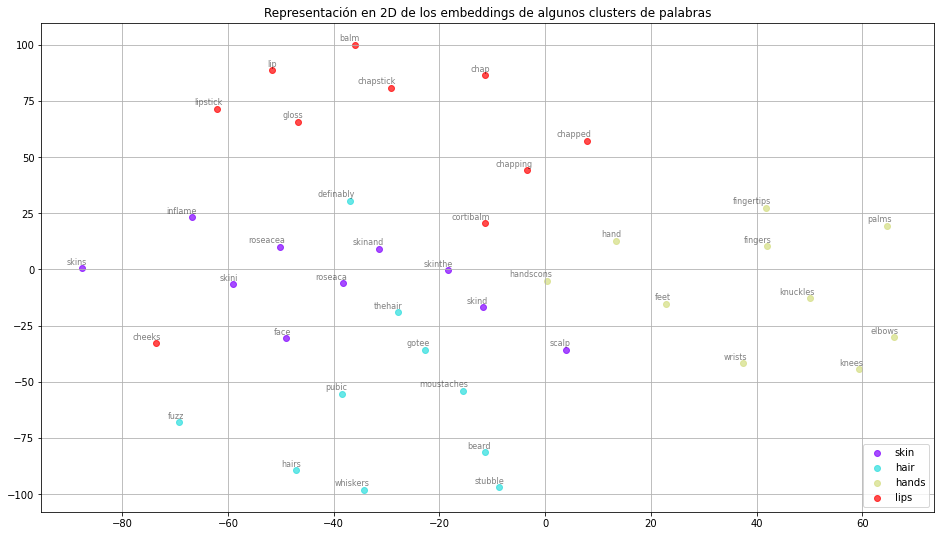

In [ ]:
tsne_plot_similar_words(keys, embeddings_2d, word_clusters)

Parece que hands se separa bastante del resto de palabras, y skin se situa entre hair y lips.

#Conclusiones de la exploración

Dataset basado en reviews de productos de belleza y cuidado personal. Dataset claramente desbalanceado, con muchas más valoraciones positivas que negativas. 

La palabra más repetida es product/products, seguido de like, use,.. Se observan palabras similares en la nube en las reviews positivas y negativas. 

En cuanto a los trigramas se observan cosas como skin care products, o color treated hair, mientras que en los bigramas vemos cosas como good product, o great product.

